In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Progbar
import numpy as np
import pandas as pd

In [2]:
torch.manual_seed(67)

In [3]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

f'{DEVICE}'

'cuda'

In [4]:
df = pd.read_csv('../data/fashion-mnist_train.csv')

In [5]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df.shape

(60000, 785)

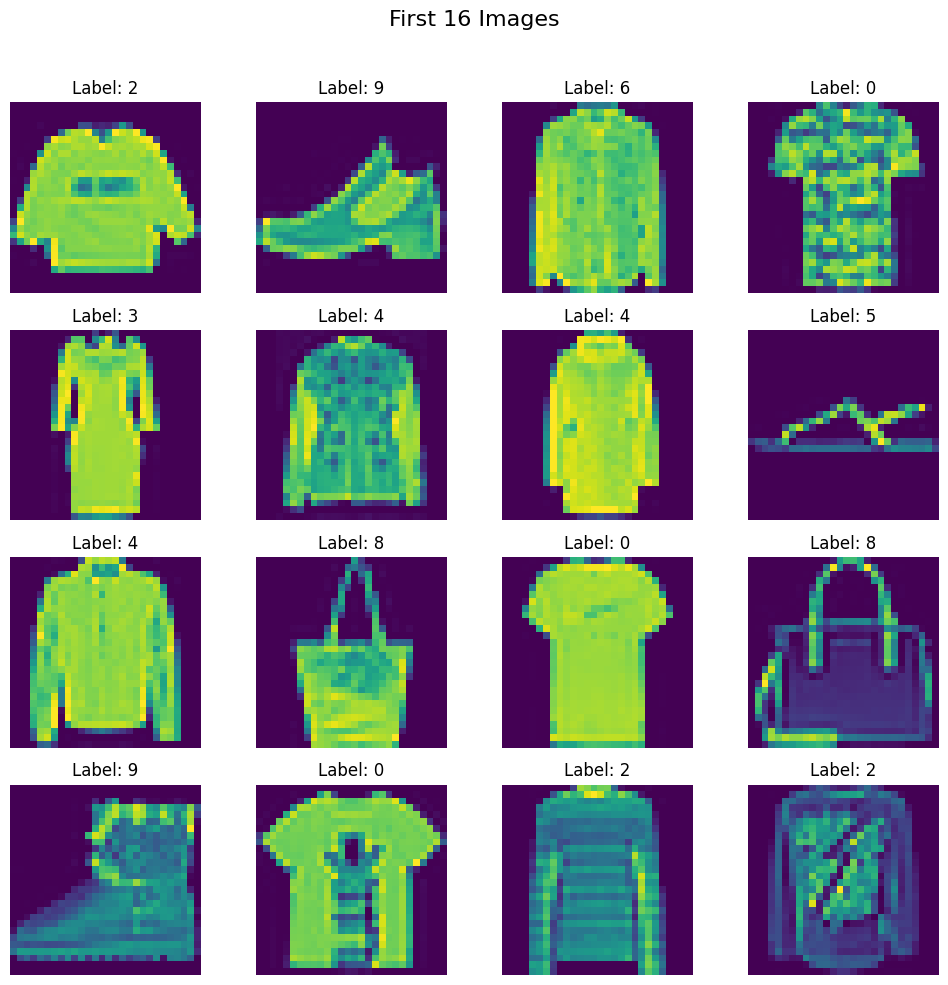

In [7]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

 
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  
    ax.imshow(img) 
    ax.axis('off')   
    ax.set_title(f"Label: {df.iloc[i, 0]}")  

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

In [8]:
X_train = df.iloc[:, 1:].values
y_train = df.iloc[:, 0].values

In [9]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(60000, 784))

In [10]:
y_train

array([2, 9, 6, ..., 8, 8, 7], shape=(60000,))

In [11]:
df_test = pd.read_csv('../data/fashion-mnist_test.csv')

In [12]:
X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

In [13]:
X_train = X_train/255.0
X_test = X_test/255.0

In [14]:
class FashionSet(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).reshape(-1,1,28,28)
        self.y = torch.tensor(y, dtype=torch.long)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [15]:
train_set = FashionSet(X_train, y_train)
test_set = FashionSet(X_test, y_test)

In [16]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

In [17]:
class ConvNet(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        
        self.ConvL = nn.Sequential(
            
            nn.Conv2d(num_features, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.FeedForwardNet = nn.Sequential(
            
            nn.Flatten(),
            
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.4),
        
            nn.Linear(64, 10)
        )
        
        
    def forward(self, X):
        
        X = self.ConvL(X)
        X = self.FeedForwardNet(X)
        
        return X

In [18]:
lr = 1e-4
epochs = 100
features = 1

In [19]:
model = ConvNet(features)

model.to(device=DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

In [20]:
num_steps_per_epoch = len(train_loader)

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    progbar = Progbar(target=num_steps_per_epoch)

    running_loss = 0.0
    
    for batch_index, (batch_features, y_true) in enumerate(train_loader, 1):
        batch_features, y_true = batch_features.to(DEVICE), y_true.to(DEVICE)
        
        y_pred = model(batch_features)
        
        loss = loss_fn(y_pred, y_true)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        avg_loss = running_loss / batch_index

        progbar.update(batch_index, values=[("loss", avg_loss)])


Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.6251

Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3532

Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2887

Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.2505

Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.2221

Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.2009

Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.1830

Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.1647

Epoch 9/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1508

Epoch 10/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1385

Epoch 11/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1246

Epoch 12/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.1136

Epoch 13/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.1063

Epoch 14/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - lo

In [21]:
model.eval

<bound method Module.eval of ConvNet(
  (ConvL): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FeedForwardNet): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)>

In [22]:
total = 0
correct = 0

num_batches = len(test_loader)
progbar = Progbar(num_batches)

with torch.no_grad():
    for batch_index, (batch_features, batch_labels) in enumerate(test_loader, 1):
        

        batch_features, batch_labels = batch_features.to(DEVICE), batch_labels.to(DEVICE)

        outputs = model(batch_features)

        _, predicted = torch.max(outputs, 1)

        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()


        progbar.update(batch_index)

print("Accuracy:", correct / total)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9179


In [23]:
total = 0
correct = 0

num_batches = len(train_loader)
progbar = Progbar(num_batches)

with torch.no_grad():
    for batch_index, (batch_features, batch_labels) in enumerate(train_loader, 1):
        

        batch_features, batch_labels = batch_features.to(DEVICE), batch_labels.to(DEVICE)

        outputs = model(batch_features)

        _, predicted = torch.max(outputs, 1)

        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()


        progbar.update(batch_index)

print("Accuracy:", correct / total)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Accuracy: 0.9946666666666667
